In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop
from tensorflow.keras import layers
import tensorflow as tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
image_size = (224, 224)
batch_size = 25

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DATA/final_data",
    validation_split=0.25,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DATA/final_data",
    validation_split=0.25,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DATA/final_data",
    validation_split=0.25,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2500 files belonging to 5 classes.
Using 1875 files for training.
Found 2500 files belonging to 5 classes.
Using 625 files for validation.
Found 2500 files belonging to 5 classes.
Using 625 files for validation.


In [8]:
train_ds

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

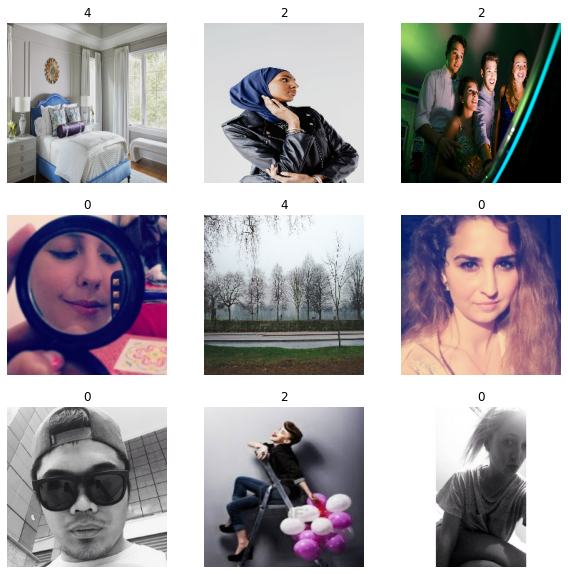

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

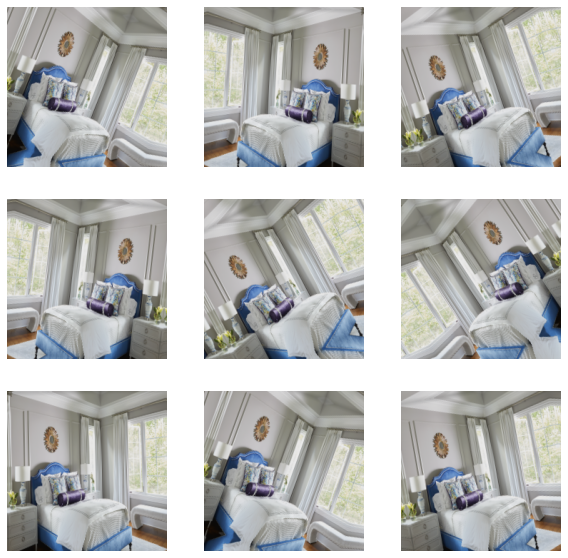

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir ='/content/drive/MyDrive/DATA/final_data' 

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_dir

'/content/drive/MyDrive/DATA/final_data/train'

# **MODEL RESNET50**

In [17]:
from tensorflow.keras.applications import ResNet50

res_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
res_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
res_base.trainable = False

In [32]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 25

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        base_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = res_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_ds, 700)
validation_features, validation_labels = extract_features(val_ds, 480)
test_features, test_labels = extract_features(test_dir, 520)

Found 2499 images belonging to 5 classes.


ValueError: ignored

In [ ]:
train_features = np.reshape(train_features, (700, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (480, 7 * 7 * 2048))
test_features = np.reshape(test_features, (520, 7 * 7 * 2048))

In [28]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 *2048))
model.add(res_base)
model.add(layers.Flatten())
model.add(layers.Dense(350, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

NameError: ignored

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10)

NameError: ignored

## **MODEL INCEPTIONV3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
base_model.trainable = False

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
#model.add(layers.InputLayer(input_shape=(224,224,3)))
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

In [ ]:
model.summary()

ValueError: ignored

In [ ]:
train=np.load('final_train_dataset.npz')
test=np.load('final_test_dataset.npz')

X_train=train['X']
y_train=train['y']
X_test=test['X']
y_test=test['y']

Exception ignored in: <function NpzFile.__del__ at 0x7ff3ba17dd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 223, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py", line 214, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


In [ ]:
test['y']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,validation_split=0.2,
      #rotation_range=10, # These are disabled for this exercise because the training would be slow
      #width_shift_range=0.01,# 
      #height_shift_range=0.01,#
      #shear_range=0.01,# 
      #zoom_range=0.01,# 
      #horizontal_flip=True,#
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        base_dir,subset='training',
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        base_dir,subset='validation',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')


history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Found 2000 images belonging to 5 classes.
Found 499 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 - 21s - loss: 0.5129 - acc: 0.7900 - val_loss: 0.5088 - val_acc: 0.7400
Epoch 2/10
20/20 - 14s - loss: 0.4977 - acc: 0.8400 - val_loss: 0.2840 - val_acc: 0.9000
Epoch 3/10
20/20 - 16s - loss: 0.4291 - acc: 0.8400 - val_loss: 0.2692 - val_acc: 0.9000
Epoch 4/10
20/20 - 14s - loss: 0.4972 - acc: 0.8250 - val_loss: 0.3201 - val_acc: 0.8600
Epoch 5/10
20/20 - 14s - loss: 0.2776 - acc: 0.9050 - val_loss: 0.3087 - val_acc: 0.8500
Epoch 6/10
20/20 - 10s - loss: 0.3083 - acc: 0.8750 - val_loss: 0.3220 - val_acc: 0.8700
Epoch 7/10
20/20 - 9s - loss: 0.4334 - acc: 0.8550 - val_loss: 0.3017 - val_acc: 0.8600
Epoch 8/10
20/20 - 11s - loss: 0.2536 - acc: 0.9050 - val_loss: 0.3349 - val_acc: 0.8700
Epoch 9/10
20/20 - 11s - loss: 0.4142 - acc: 0.8750 - val_loss: 0.3250 - val_acc: 0.8600
Epoch 10/10
20/20 - 9s - loss: 0.2457 - acc: 0.9200 - val_loss: 0.3108 - val_acc: 0.9100
